In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import utils
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DIR_PATH = "Data"
DIRPATH_EXTRACTED_FEATURES = "extracted_features"

In [2]:
class CustomDataset(Dataset):
    def __init__(self, brands: list, filenames_features: list, filename_target=utils.FILENAME_RELEVANCE_WINDOW, 
                 log_target=False, center_target=False, filter_uniform_features=False, device=device):
        self.log_target = log_target
        self.center_target = center_target
        self.device = device
        self.features = torch.concat([torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_feature), map_location=device) 
                         for filename_feature in filenames_features], dim=1)
                            for brand in brands], dim=0)
        self.target = torch.concat([torch.load(os.path.join(DIRPATH_EXTRACTED_FEATURES, brand, filename_target), map_location=device) 
                            for brand in brands], dim=0)
        if log_target:
            self.target = torch.log(self.target)
        if center_target:
            self.target = self.target - self.target.mean()
        self.filter_uniform_features = filter_uniform_features
        if self.filter_uniform_features:
            self.features = self.features[:,(self.features != self.features[0]).any(0)]

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]
    

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=nn.ReLU(), batchnorm=False):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential()
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(input_size, hidden_size))
            if batchnorm:
                self.layers.append(nn.BatchNorm1d(hidden_size))
            self.layers.append(activation_fn)
            input_size = hidden_size
        self.layers.append(nn.Linear(input_size, output_size))
    
    def forward(self, x):
        out = self.layers(x)
        return out
    

class TargetWeightedLoss(nn.Module):
    def __init__(self, target_bincount):
        super(TargetWeightedLoss, self).__init__()
        self.target_bincount = 1 / (target_bincount.float() + 1)
    
    def forward(self, output, target):
        loss = torch.mean((torch.abs(output - target)**2 * self.target_bincount[target.int()]))
        return loss    
    

class LNLoss(nn.Module):
    def __init__(self, N):
        super(LNLoss, self).__init__()
        self.N = N
    
    def forward(self, output, target):
        loss = torch.mean(torch.abs(output - target)**self.N)
        return loss

In [3]:
filenames_features = [utils.FILENAME_BRAND_OHE,
utils.FILENAME_PUBLICATION_TIMESTAMP,
utils.FILENAME_PUBLICATION_WEEKDAY_OHE,
utils.FILENAME_NUM_WORDS,
utils.FILENAME_NUM_PARAGRAPH,
# utils.FILENAME_MAIN_SECTION_OHE,
# utils.FILENAME_SUBSECTIONS_OHE,
utils.FILENAME_USER_NEEDS,
utils.FILENAME_LDA_TOPICS,
utils.FILENAME_IPTC_TOPICS_LEVEL_0,
utils.FILENAME_IPTC_TOPICS_LEVEL_1,
]

brands = utils.ALL_BRANDS

dataset = CustomDataset(brands, filenames_features, filter_uniform_features=False, log_target=True, center_target=True)
dataset.features.shape

torch.Size([213466, 173])

In [4]:
batch_size = 1024 
train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
EPOCHS = 30
train_loss = []
test_loss = []
model = SimpleMLP(input_size=dataset.features.shape[1], hidden_sizes=[128,128], output_size=1, batchnorm=True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

eval_per_n_batches = 10

loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
# loss_fn = TargetWeightedLoss(torch.bincount(dataset.target.int().squeeze()).to(device))
# loss_fn = LNLoss(4)


for epoch in range(EPOCHS):

    model.train(True)
    
    running_loss = 0.

    for i, data in enumerate(train_dataloader):
        model.train(True)
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % eval_per_n_batches == (eval_per_n_batches-1):
            avg_loss = running_loss / eval_per_n_batches 
            train_loss.append(avg_loss)

            running_loss = 0.

            running_vloss = 0.0

            model.eval()
            with torch.no_grad():
                for i, vdata in enumerate(test_dataloader):
                    vinputs, vlabels = vdata
                    voutputs = model(vinputs)
                    vloss = loss_fn(voutputs, vlabels)
                    running_vloss += vloss 

            avg_vloss = running_vloss / len(test_dataloader)
            test_loss.append(avg_vloss.item())
    print(f"finished epoch {epoch+1}/{EPOCHS} with eval loss {test_loss[-1]:.3f}")

finished epoch 1/30 with eval loss 0.617
finished epoch 2/30 with eval loss 0.613
finished epoch 3/30 with eval loss 0.611
finished epoch 4/30 with eval loss 0.605
finished epoch 5/30 with eval loss 0.576
finished epoch 6/30 with eval loss 0.568
finished epoch 7/30 with eval loss 0.562
finished epoch 8/30 with eval loss 0.558
finished epoch 9/30 with eval loss 0.558
finished epoch 10/30 with eval loss 0.551
finished epoch 11/30 with eval loss 0.544
finished epoch 12/30 with eval loss 0.539
finished epoch 13/30 with eval loss 0.534
finished epoch 14/30 with eval loss 0.531
finished epoch 15/30 with eval loss 0.528
finished epoch 16/30 with eval loss 0.526
finished epoch 17/30 with eval loss 0.521
finished epoch 18/30 with eval loss 0.520
finished epoch 19/30 with eval loss 0.507
finished epoch 20/30 with eval loss 0.503


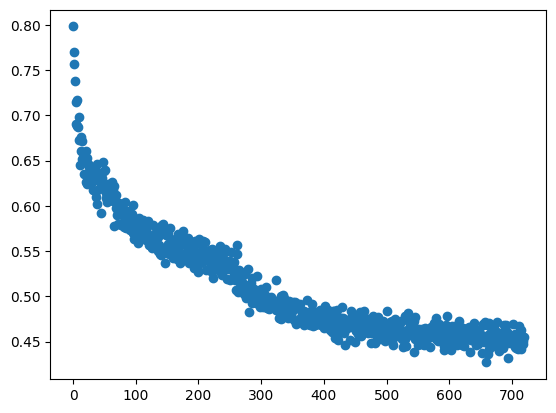

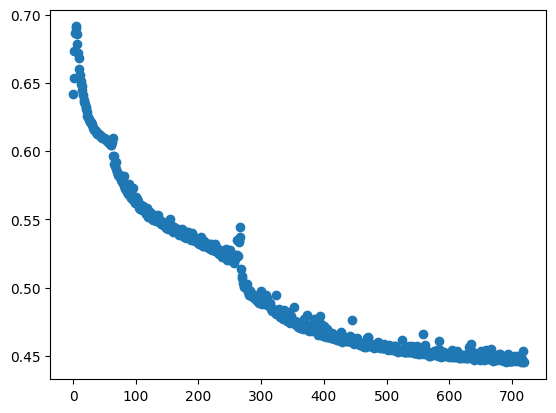

In [ ]:
plt.scatter(range(len(train_loss)), train_loss)
plt.show()
plt.scatter(range(len(test_loss)), test_loss)
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    y_train = dataset[train_dataset.indices][1].cpu()
    y_pred_train = model(dataset[train_dataset.indices][0]).cpu()
    abs_dif_train = torch.abs(y_pred_train - y_train)

    y_test = dataset[test_dataset.indices][1].cpu()
    y_pred_test = model(dataset[test_dataset.indices][0]).cpu()
    abs_dif_test = torch.abs(y_pred_test - y_test)


tensor(0.4966) tensor(0.4545)
tensor(0.4943) tensor(0.4508)


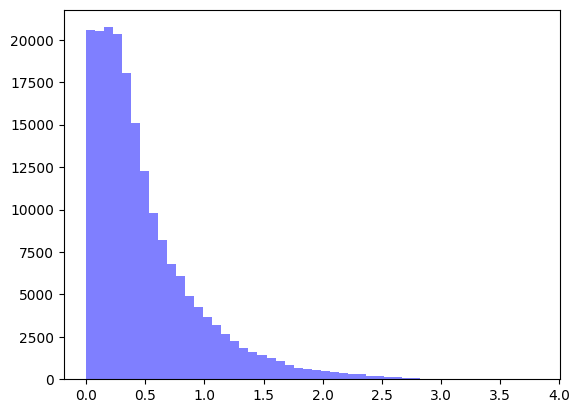

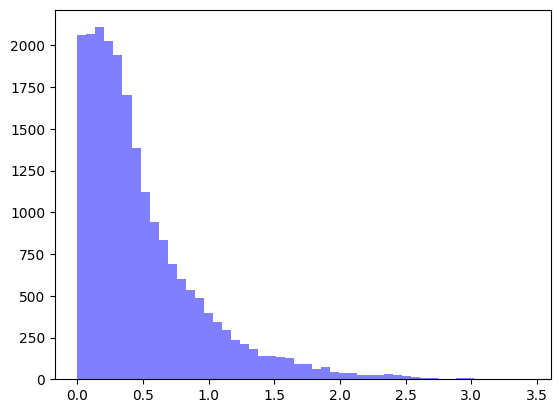

In [ ]:
print(abs_dif_train.mean(), abs_dif_train.std())
print(abs_dif_test.mean(), abs_dif_test.std())
plt.hist(abs_dif_train, bins=50, alpha=0.5, color='b')
plt.show()
plt.hist(abs_dif_test, bins=50, alpha=0.5, color='b')
plt.show()

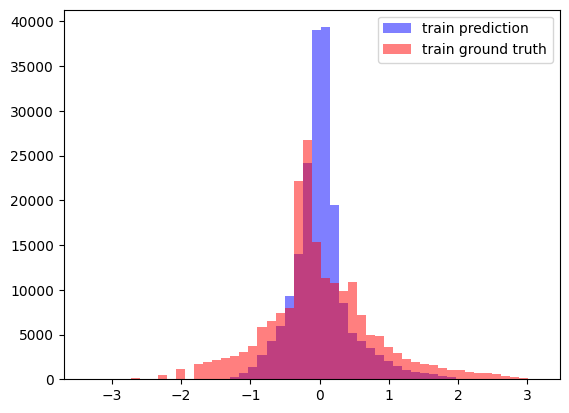

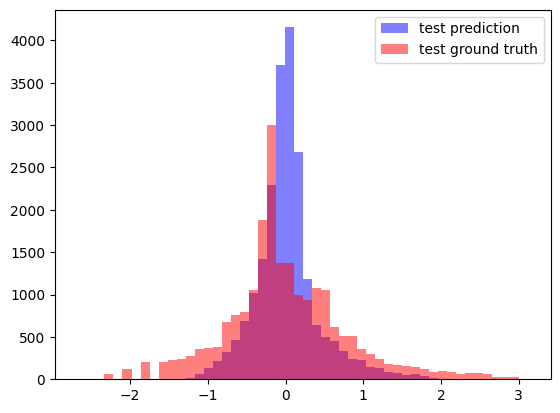

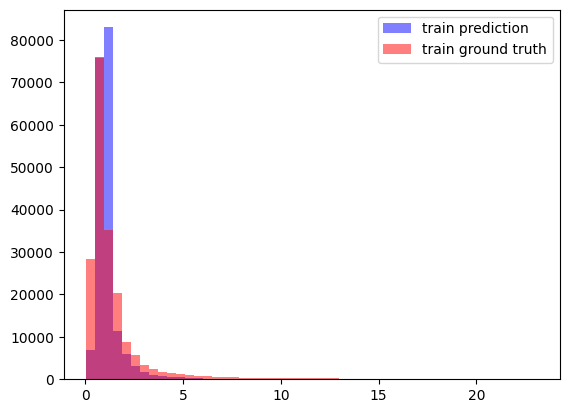

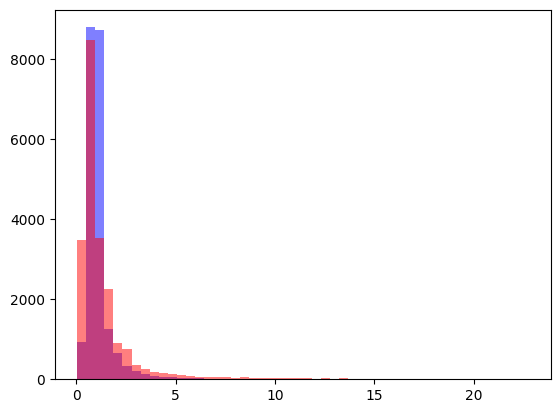

In [ ]:
n_bins = 50
bins = np.histogram(np.hstack((y_pred_train,y_train)), bins=n_bins)[1]
plt.hist(y_pred_train, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test,y_test)), bins=n_bins)[1]
plt.hist(y_pred_test, bins=bins, alpha=0.5, color='b', label='test prediction')
plt.hist(y_test, bins=bins, alpha=0.5, color='r', label='test ground truth')
plt.legend()
plt.show()

if dataset.log_target:
    y_pred_train_trans = torch.exp(y_pred_train)
    y_train_trans = torch.exp(y_train)
    y_pred_test_trans = torch.exp(y_pred_test)
    y_test_trans = torch.exp(y_test)
else:
    y_pred_train_trans = torch.log(y_pred_train)
    y_train_trans = torch.log(y_train)
    y_pred_test_trans = torch.log(y_pred_test)
    y_test_trans = torch.log(y_test)

bins = np.histogram(np.hstack((y_pred_train_trans,y_train_trans)), bins=n_bins)[1]
plt.hist(y_pred_train_trans, bins=bins, alpha=0.5, color='b', label='train prediction')
plt.hist(y_train_trans, bins=bins, alpha=0.5, color='r', label='train ground truth')
plt.legend()
plt.show()

bins = np.histogram(np.hstack((y_pred_test_trans,y_test_trans)), bins=n_bins)[1]
plt.hist(y_pred_test_trans, bins=bins, alpha=0.5, color='b')
plt.hist(y_test_trans, bins=bins, alpha=0.5, color='r')
plt.show()